<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#oncogenicity" data-toc-modified-id="oncogenicity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>oncogenicity</code></a></span></li><li><span><a href="#Alternative-amino-acid" data-toc-modified-id="Alternative-amino-acid-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Alternative amino-acid</a></span></li><li><span><a href="#High-cosmic_count" data-toc-modified-id="High-cosmic_count-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>High <code>cosmic_count</code></a></span></li><li><span><a href="#Other-tools-available" data-toc-modified-id="Other-tools-available-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Other tools available</a></span><ul class="toc-item"><li><span><a href="#CIViC" data-toc-modified-id="CIViC-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CIViC</a></span></li><li><span><a href="#Cancer-Genome-Interpreter" data-toc-modified-id="Cancer-Genome-Interpreter-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cancer Genome Interpreter</a></span></li><li><span><a href="#My-Cancer-Genome" data-toc-modified-id="My-Cancer-Genome-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>My Cancer Genome</a></span></li></ul></li></ul></div>

# OncoKB driver annotations study

Created: **23/07/18**  
Last modified: **23/07/18**

**Goal:** ...  
This notebook is divided in ? parts:
* **1. Bla**: Bla

**Refs:**
* `annotating.ipynb` [Pierre]
* `custom_tools.R` [Pierre]
***

In [1]:
source("custom_tools.R")
setup_environment()

In [2]:
impact <- get_cleaned_impact()
impact <- add_features(impact, annotations = TRUE, oncokb = TRUE)

Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 1 has 248513 rows to replace 248498 rows”Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 2 has 248513 rows to replace 248498 rows”Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 3 has 248513 rows to replace 248498 rows”

## `oncogenicity`


   not_in_oncokb Likely Oncogenic        Oncogenic     Inconclusive 
          194256            43717            14036              528 
  Likely Neutral              Sum 
             235           252772 

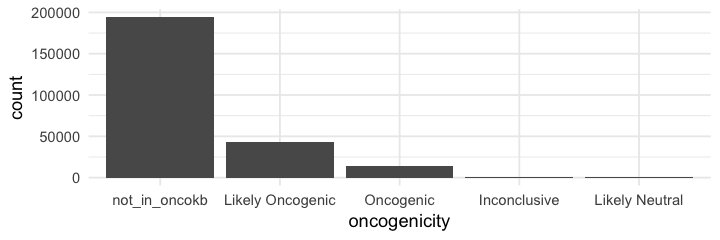

In [3]:
impact <- sort_histogram(impact, "oncogenicity")
addmargins(rev(sort(table(impact$oncogenicity))))
notebook_plot_size(6, 2)
ggplot(impact) + geom_bar(aes(oncogenicity))

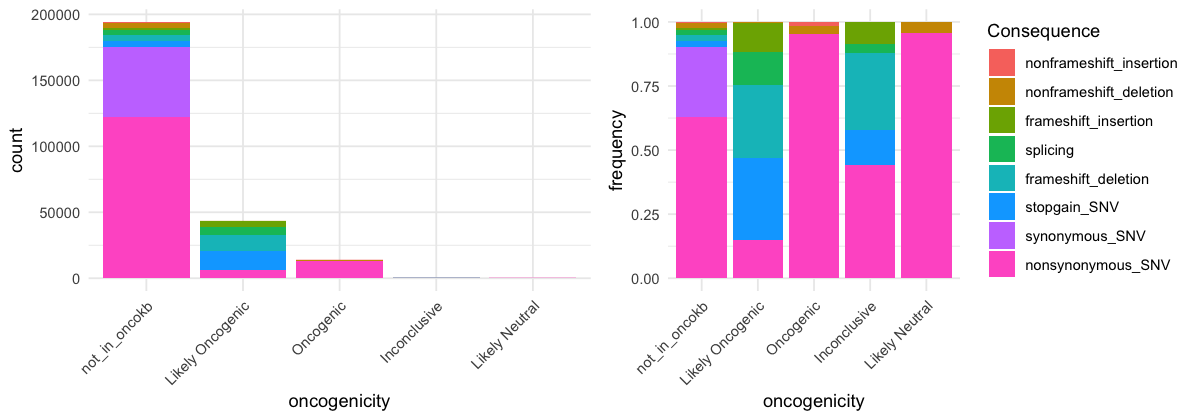

In [4]:
plot_contingency_table_as_histograms(impact, "oncogenicity", "Consequence")

Non of the synonymous mutations are in OncoKB.

In [5]:
nrow(impact[impact$Consequence == "synonymous_SNV" & impact$oncogenicity != "not_in_oncokb",])

[1] 0

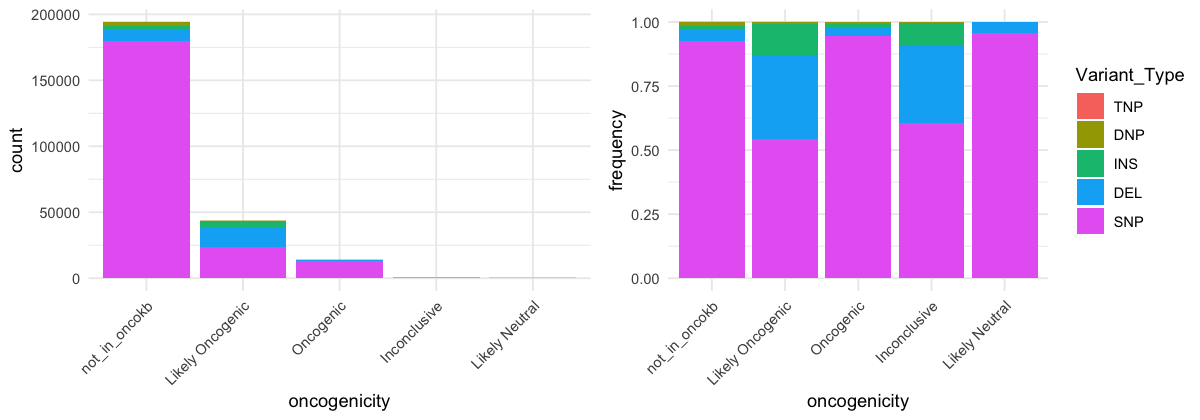

In [6]:
plot_contingency_table_as_histograms(impact, "oncogenicity", "Variant_Type")

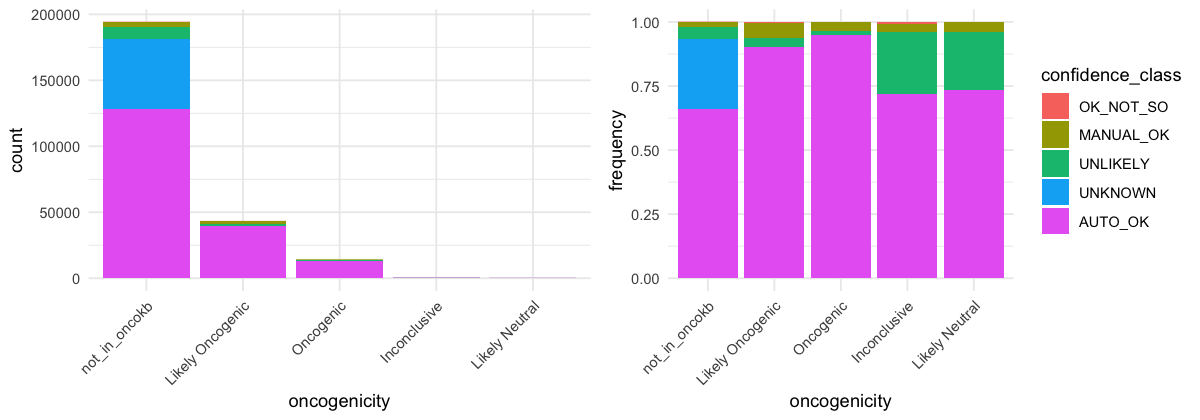

In [7]:
plot_contingency_table_as_histograms(impact, "oncogenicity", "confidence_class")

In [8]:
drivers <- impact[impact$oncogenicity %in% c("Oncogenic", "Likely Oncogenic"),]
nrow(drivers)

[1] 57753

In [9]:
source("custom_tools.R")

[1] 231

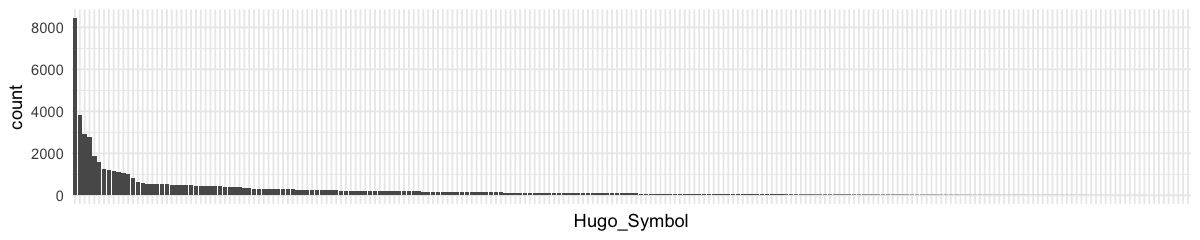

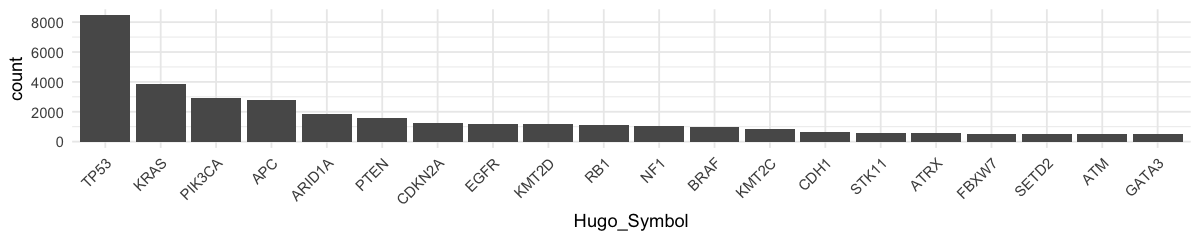

In [10]:
length(unique(drivers$Hugo_Symbol))
drivers <- sort_histogram(drivers, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(drivers) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(drivers, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Alternative amino-acid

We will only work on the somatic and nonsynonymous mutations:

In [4]:
impact <- impact[impact$confidence_class == "AUTO_OK" | impact$confidence_class == "MANUAL_OK",]

In [12]:
addmargins(rev(sort(table(impact$oncogenicity))))


   not_in_oncokb Likely Oncogenic        Oncogenic     Inconclusive 
          131956            42101            13839              395 
  Likely Neutral              Sum 
             182           188473 

In [13]:
oncokb <- read.table("data/allAnnotatedVariants.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
oncokb$key <- paste0(oncokb$Gene, '.p.',oncokb$Alteration)

# create the impact `oncokb_key`
impact$oncokb_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)

impact$oncokb_key[impact$Consequence == "splicing" | impact$HGVSp_Short == ''] <- 'other'
is_truncating <- which(impact$Consequence %in% c("frameshift_deletion", "frameshift_insertion",
                                                 "stopgain_SNV", "splicing"))
impact$oncokb_key[is_truncating] <- paste0(impact$Hugo_Symbol[is_truncating], '.p.Truncating Mutations')

In [14]:
length(impact$oncokb_key[impact$oncogenicity == "not_in_oncokb"])
head(impact$oncokb_key)

[1] 131956

[1] "TP53.p.T256P"                 "PIK3R3.p.I298M"              
[3] "ATR.p.R2431M"                 "PDGFRA.p.L465M"              
[5] "FBXW7.p.Truncating Mutations" "FBXW7.p.Truncating Mutations"

In [15]:
get_alternative_keys_in_oncokb <- function(key) {
    amino_acid_list = c('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                        'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    if (grepl("Truncating Mutations", key)) {
        return ('')
    }
    
    else {
        amino_acid_list <- amino_acid_list[amino_acid_list != substr(key, nchar(key), nchar(key))]
        alt_keys <- paste0(substr(key, 1, nchar(key)-1), amino_acid_list)
        in_oncokb <- which(alt_keys %in% oncokb$key)
        
        if (sum(in_oncokb))
            return (c(key, alt_keys[in_oncokb]))
        else
            return ('')
    }
}

get_alternative_keys_in_oncokb("MAP2K4.p.R154A")
get_alternative_keys_in_oncokb("TP53.p.T256P")
get_alternative_keys_in_oncokb('FBXW7.p.Truncating Mutations')

[1] "MAP2K4.p.R154A" "MAP2K4.p.R154W"

[1] ""

[1] ""

In [3]:
impact_not_in_oncokb <- impact[impact$oncogenicity == "not_in_oncokb",]

In [11]:
dd <- sapply(unique(impact_not_in_oncokb$oncokb_key), get_alternative_keys_in_oncokb)
dd <- unique(dd[dd != ''])

ERROR: Error in match.fun(FUN): object 'get_alternative_keys_in_oncokb' not found


In [17]:
sprintf("%.2f%% (%d) of the impact oncokb_keys are concerned",
        length(dd) / length(unique(impact$oncokb_key)) * 100,
        length(dd))
head(dd)

[1] "1.36% (1335) of the impact oncokb_keys are concerned"

[[1]]
[1] "PTEN.p.L23V" "PTEN.p.L23F"

[[2]]
[1] "TP53.p.I255T" "TP53.p.I255F"

[[3]]
[1] "GNAS.p.Q227K" "GNAS.p.Q227R" "GNAS.p.Q227L"

[[4]]
[1] "SMAD4.p.D537V" "SMAD4.p.D537E" "SMAD4.p.D537Y"

[[5]]
[1] "FGFR4.p.V550L" "FGFR4.p.V550E"

[[6]]
[1] "TSC1.p.L191I" "TSC1.p.L191H"

In [18]:
table( sapply(dd, function(d) length(unique(d))-1) ) # number of viable replacements


  1   2   3   4   5   6   7 
918 229 120  46  19   1   2 

## High `cosmic_count`

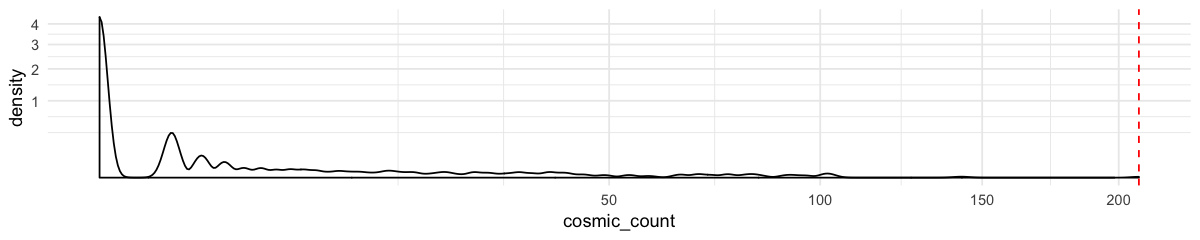

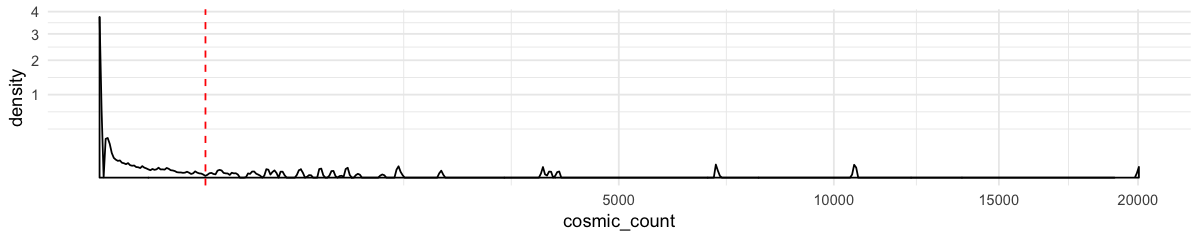

In [7]:
notebook_plot_size(10, 2)
ggplot(impact_not_in_oncokb) + geom_density(aes(cosmic_count)) + scale_x_sqrt() + scale_y_sqrt() +
        geom_vline(aes(xintercept = max(impact_not_in_oncokb)), linetype = "dashed", color = "red")
ggplot(impact) + geom_density(aes(cosmic_count)) + scale_x_sqrt() + scale_y_sqrt() +
        geom_vline(aes(xintercept = max(impact_not_in_oncokb)), linetype = "dashed", color = "red")

## Other tools available

### CIViC

**[CIViC](https://civicdb.org/)**  
See https://civicdb.org/faq for informations:  
* CIViC is an open access, open source, community-driven web resource for Clinical Interpretation of Variants in Cancer.
* Validated curators can add a variant description if there is evidence link to cancer with some clinical relevance.
* They can discuss significance of cancer genome alterations on a forum-based platform.
* CIViC accepts somatic variants, germline variants, and common polymorphisms related to cancer (as long as they have clinical relevance), however, most variants in CIViC are somatic mutations.

It is a crowdsourcing OncoKB.

Data downloaded from https://civicdb.org/releases under "Variant Summaries", 01/07/18 version.

In [47]:
civic <- read.table("data/other_databases/CIViC_Variant_Summaries.txt",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [48]:
length(unique(civic$gene))
nrow(civic)

[1] 353

[1] 1885

In [49]:
colnames(civic)

[1] "variant_id"                 "variant_civic_url"         
 [3] "gene"                       "entrez_id"                 
 [5] "variant"                    "summary"                   
 [7] "variant_groups"             "chromosome"                
 [9] "start"                      "stop"                      
[11] "reference_bases"            "variant_bases"             
[13] "representative_transcript"  "ensembl_version"           
[15] "reference_build"            "chromosome2"               
[17] "start2"                     "stop2"                     
[19] "representative_transcript2" "variant_types"             
[21] "hgvs_expressions"           "last_review_date"          
[23] "civic_actionability_score"

In [53]:
civic <- civic[, c("gene",
                   "variant",
                   "chromosome",
                   "start",
                   "stop",
                   "reference_bases",
                   "variant_bases",
                   "variant_types",
                   "civic_actionability_score",
                   "hgvs_expressions")]
head(civic, 10)

gene,variant,chromosome,start,stop,reference_bases,variant_bases,variant_types,civic_actionability_score,hgvs_expressions
ABL1,BCR-ABL,22,23522397,23632600,,,transcript_fusion,238.0,
ABL1,BCR-ABL T334I,9,133748283,133748283,C,T,"transcript_fusion,missense_variant",54.0,"NM_007313.2:c.1001C>T,NP_005148.2:p.Thr315Ile,ENST00000372348.2:c.1001C>T,NC_000009.11:g.133748283C>T"
ABL1,BCR-ABL E255K,9,133738363,133738363,G,A,"transcript_fusion,missense_variant",17.0,"NC_000009.11:g.133738363G>A,NM_005157.5:c.763G>A,NP_005148.2:p.Glu255Lys,ENST00000318560.5:c.763G>A"
AKT1,E17K,14,105246551,105246551,C,T,missense_variant,32.5,"NC_000014.8:g.105246551C>T,NM_001014432.1:c.49G>A,NP_001014432.1:p.Glu17Lys,ENST00000407796.2:c.49G>A"
ALK,EML4-ALK,2,42396490,42522656,,,transcript_fusion,48.0,
ALK,EML4-ALK C1156Y,2,29445258,29445258,C,T,"transcript_fusion,missense_variant",19.0,"ENST00000389048.3:c.3467G>A,NC_000002.11:g.29445258C>T,NM_004304.4:c.3467G>A,NP_004295.2:p.Cys1156Tyr"
ALK,EML4-ALK L1196M,2,29443631,29443631,G,T,"transcript_fusion,missense_variant",31.0,"ENST00000389048.3:c.3586C>A,NC_000002.11:g.29443631G>T,NM_004304.4:c.3586C>A,NP_004295.2:p.Leu1196Met"
ALK,F1174L,2,29443695,29443695,G,T,missense_variant,33.5,"NM_004304.4:c.3522C>A,NP_004295.2:p.Phe1174Leu,NC_000002.11:g.29443695G>T,ENST00000389048.3:c.3522C>A"
ALK,R1275Q,2,29432664,29432664,C,T,missense_variant,23.0,"NM_004304.4:c.3824G>A,NP_004295.2:p.Arg1275Gln,NC_000002.11:g.29432664C>T,ENST00000389048.3:c.3824G>A"
ARAF,S214C,X,47426121,47426121,C,G,missense_variant,11.0,"NC_000023.10:g.47426121C>G,NM_001654.4:c.641C>G,NP_001645.1:p.Ser214Cys,ENST00000377045.4:c.641C>G"



FALSE 
 1885 

In [72]:
civic$mut_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep="_")

In [78]:
impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$mut_key] <- "yes"

In [79]:
table(impact$is_in_civic)


    no    yes 
235637  12861 

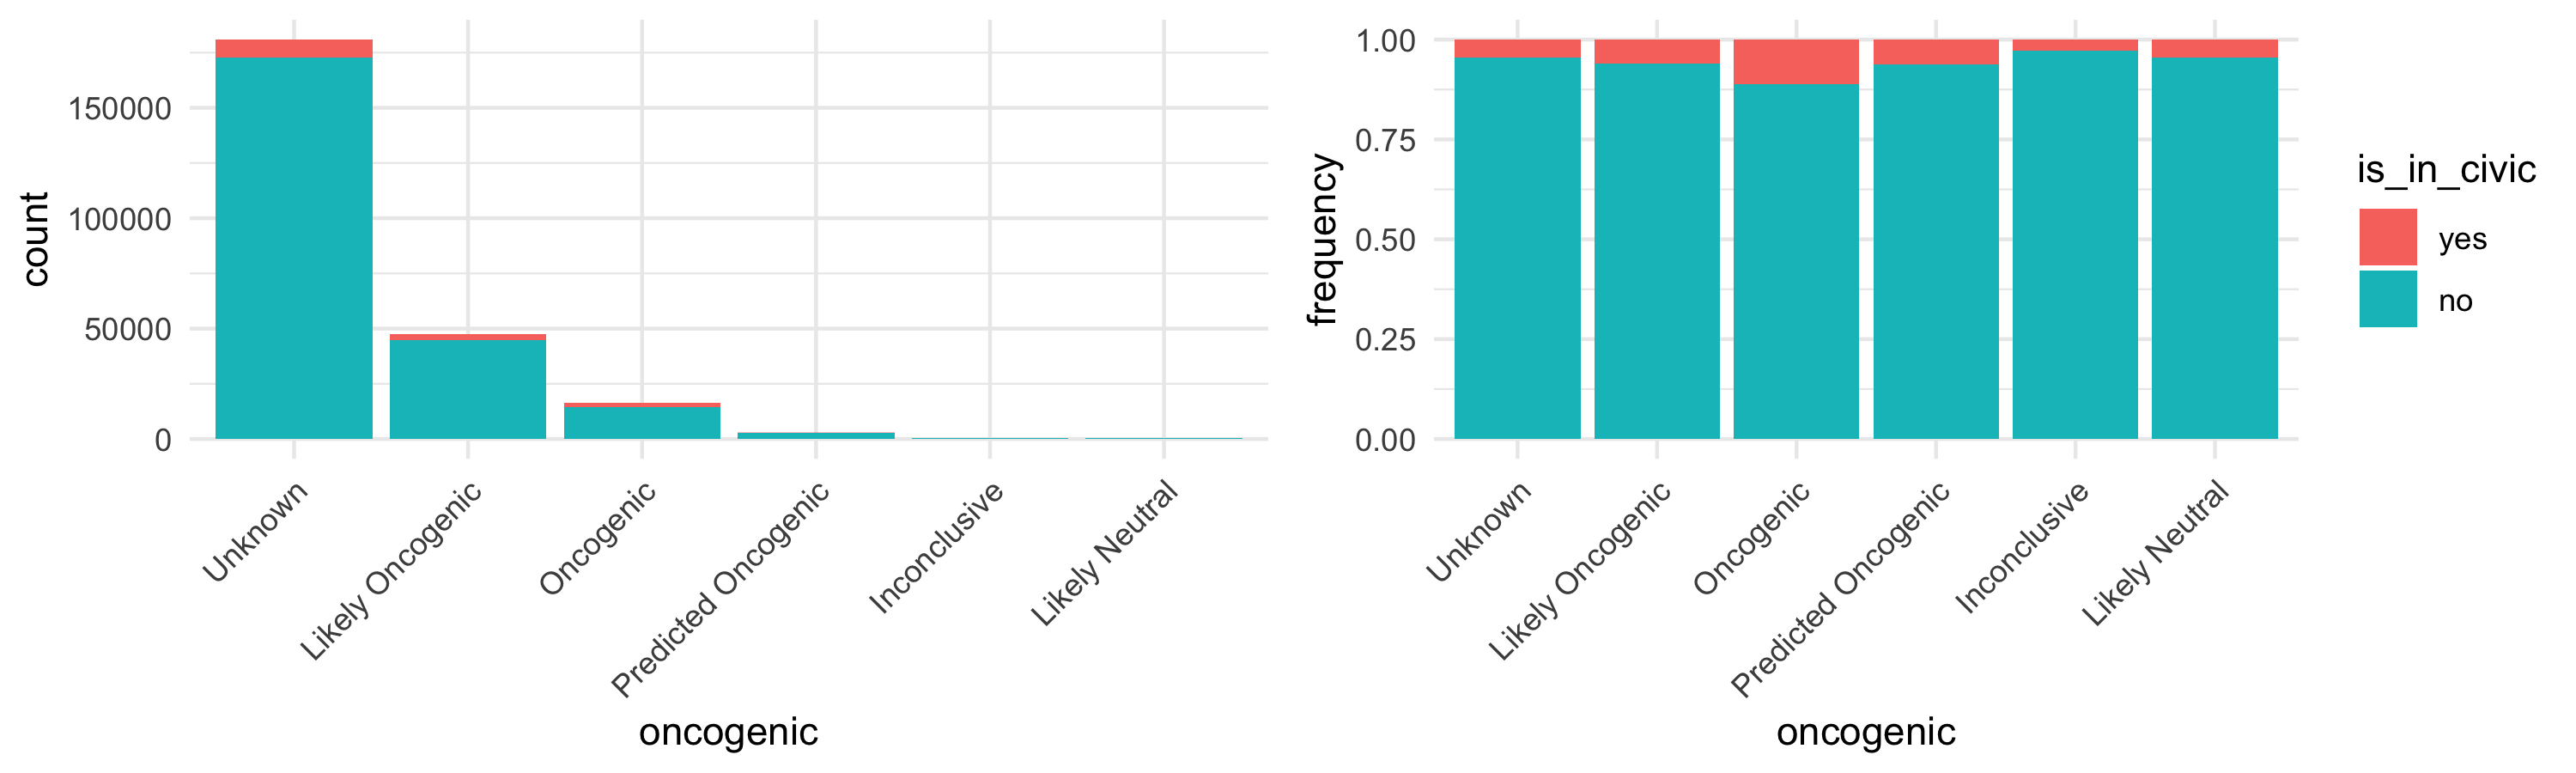

In [84]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_civic")

### Cancer Genome Interpreter

**[Cancer Genome Interpreter](https://www.cancergenomeinterpreter.org/home)**  
See https://www.cancergenomeinterpreter.org/faq for informations:  
* Designed to support the identification of tumor alterations that drive the disease and detect those that may be therapeutically actionable.
* CGI relies on existing knowledge collected from several resources and on computational methods that annotate the alterations in a tumor according to distinct levels of evidence.
* It identifies known driver alterations and annotates and classifies the remaining variants of unknown significance. Finally, alterations that are biomarkers of drug effect are identified according to current evidences.
* Alterations that are clinically or experimentally validated to drive tumor phenotypes –previously culled from public sources-- are identified by the CGI, whereas the effect of the remaining alterations of uncertain significance are predicted using in silico approaches, such as OncodriveMUT (for mutations).

It is OncoKB + OncodriveMUT.

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [90]:
cgi <- read.table("data/other_databases/catalog_of_validated_oncogenic_mutations.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [91]:
head(cgi)

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040


In [93]:
length(unique(cgi$gene))
nrow(cgi)

[1] 247

[1] 5601

In [97]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

In [98]:
table(impact$is_in_cgi)


    no    yes 
219825  28673 

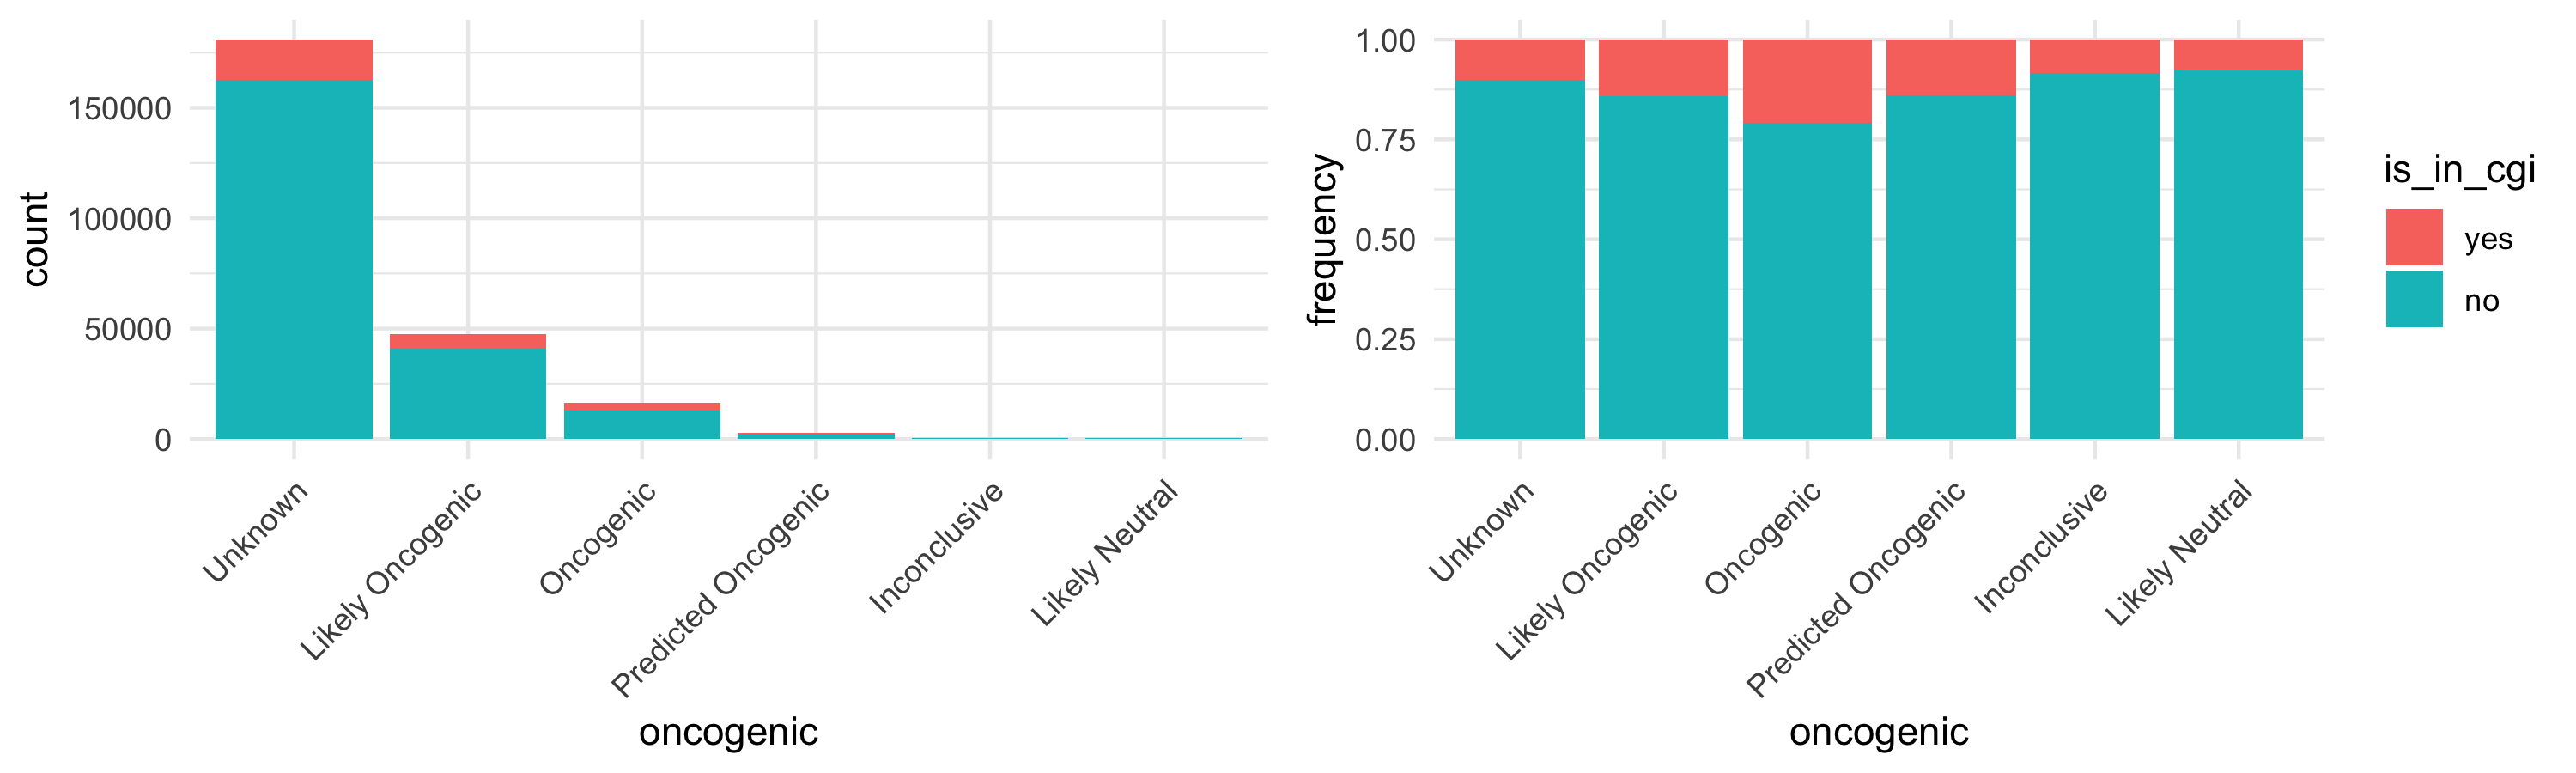

In [99]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_cgi")

### My Cancer Genome

**[My Cancer Genome](https://www.mycancergenome.org)**  
See https://www.mycancergenome.org/about/what-is-my-cancer-genome/ for informations:
* My Cancer Genome is a precision cancer medicine knowledge resource for physicians, patients, caregivers and researchers.
* It gives information on what mutations make cancers grow and related therapeutic implications, including available clinical trials.

It is OncoKB.

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [90]:
cgi <- read.table("data/other_databases/catalog_of_validated_oncogenic_mutations.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [91]:
head(cgi)

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040


In [93]:
length(unique(cgi$gene))
nrow(cgi)

[1] 247

[1] 5601

In [97]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

In [98]:
table(impact$is_in_cgi)


    no    yes 
219825  28673 

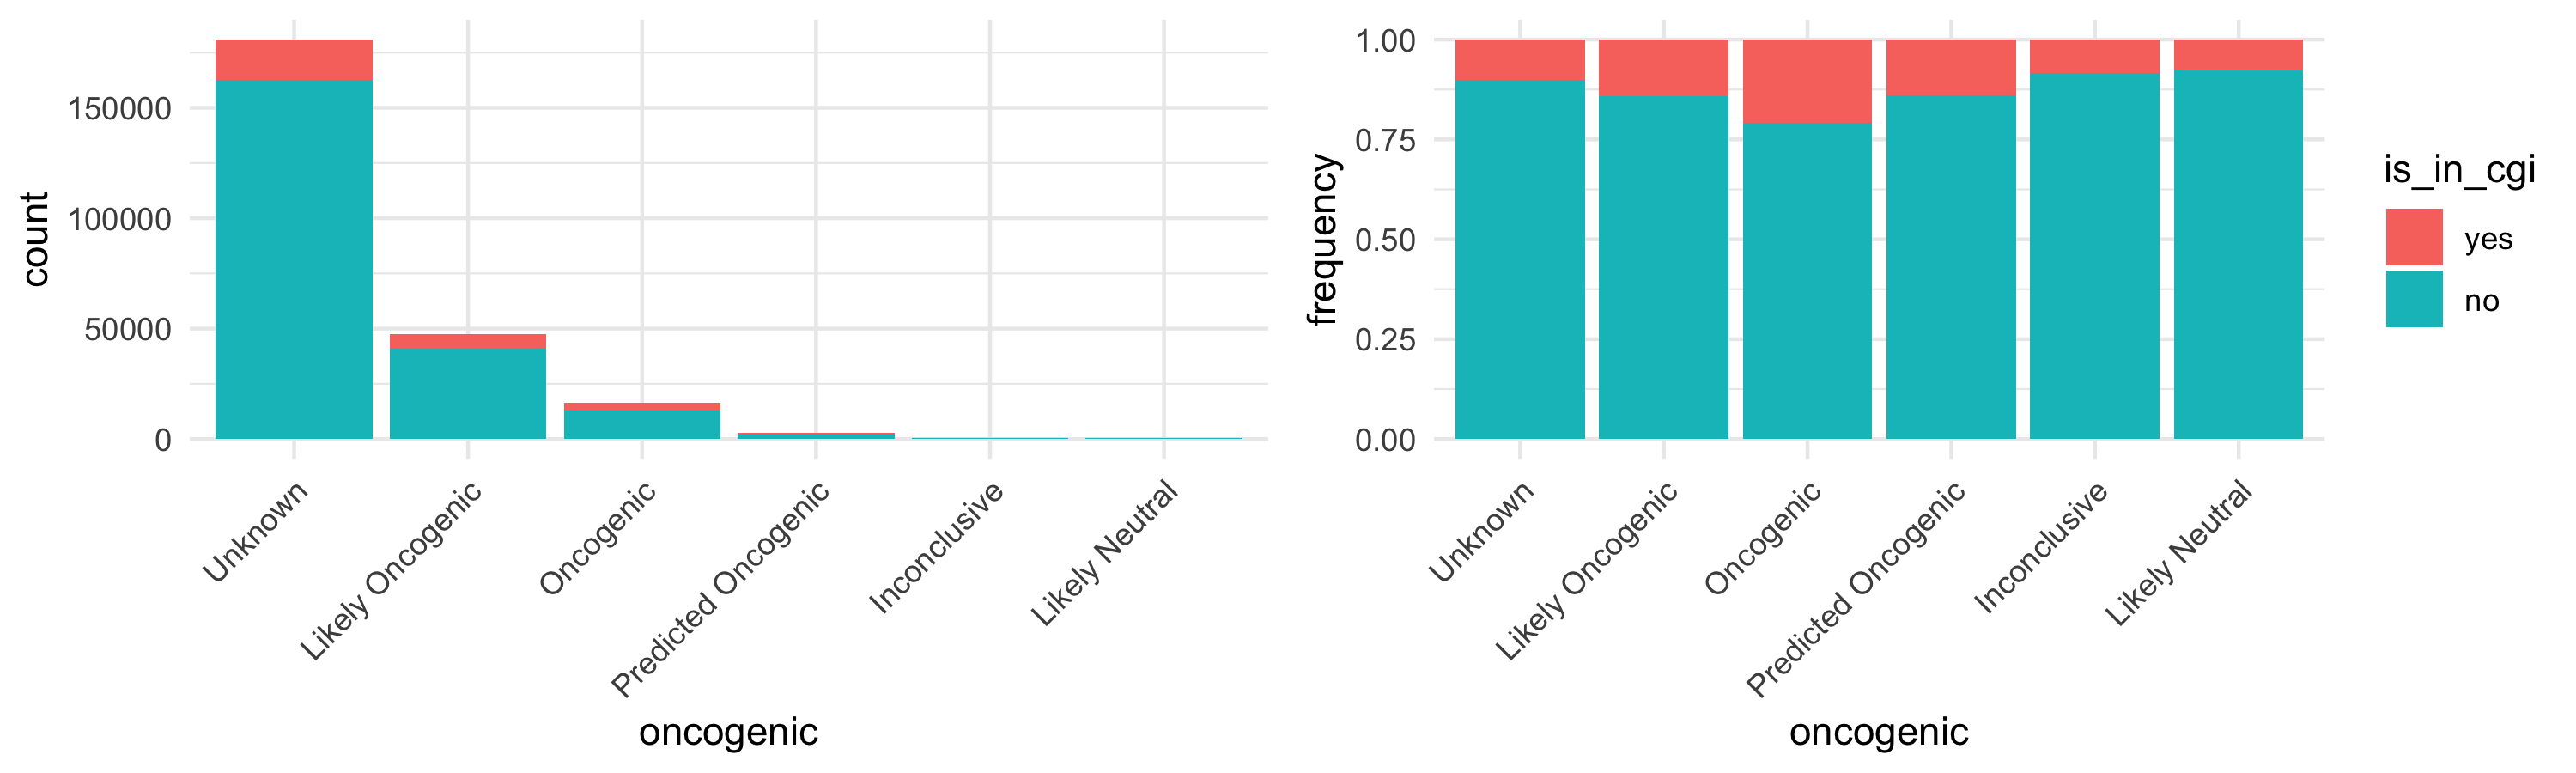

In [99]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_cgi")